In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [72]:
img_ref = cv2.imread('./frame000000.jpg')[:,:,::-1]
img_next = cv2.imread('./frame000334.jpg')[:,:,::-1]

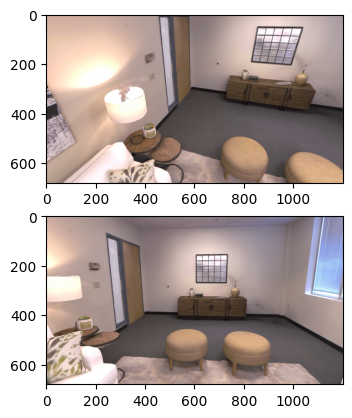

In [73]:
plt.subplot(2,1,1)
plt.imshow(img_ref)
plt.subplot(2,1,2)
plt.imshow(img_next)

## Keypoint Detection

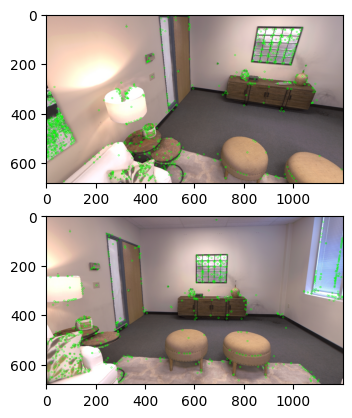

In [74]:
# create orb detector
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_ref,None)
kp2, des2 = sift.detectAndCompute(img_next,None)

vis1 = cv2.drawKeypoints(img_ref, kp1, None, color=(0,255,0), flags=0)
vis2 = cv2.drawKeypoints(img_next, kp2, None, color=(0,255,0), flags=0)

plt.subplot(2,1,1)
plt.imshow(vis1)
plt.subplot(2,1,2)
plt.imshow(vis2)
plt.show()

# Keypoint Matching

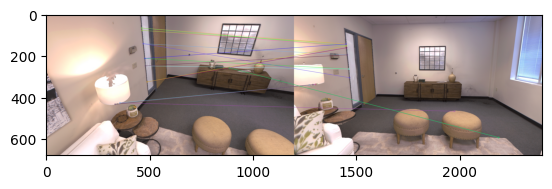

In [75]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

#sort matches by best
matches = sorted(matches, key = lambda x:x[0].distance)

img3 = cv2.drawMatchesKnn(img_ref,kp1,img_next,kp2,matches[:10],None,flags=2)
plt.imshow(img3)

## Get Fundamental Matrix

In [84]:
'''
dataset_name: 'replica'
camera_params:
  image_height: 680
  image_width: 1200
  fx: 600.0
  fy: 600.0
  cx: 599.5
  cy: 339.5
  png_depth_scale: 6553.5
  crop_edge: 0
'''
fx = 600.0
fy = 600.0
cx = 599.5
cy = 339.5

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

pts_l = []
pts_r = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.5*n.distance:
        pts_l.append(kp1[m.queryIdx].pt)
        pts_r.append(kp2[m.trainIdx].pt)

pts_l_norm = cv2.undistortPoints(np.expand_dims(pts_l, axis=1), cameraMatrix=K, distCoeffs=None)
pts_r_norm = cv2.undistortPoints(np.expand_dims(pts_r, axis=1), cameraMatrix=K, distCoeffs=None)

E, mask = cv2.findEssentialMat(pts_l_norm, pts_r_norm, focal=1.0, pp=(0., 0.), method=cv2.RANSAC, prob=0.999, threshold=3.0)
points, R, t, mask = cv2.recoverPose(E, pts_l_norm, pts_r_norm)

M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
M_r = np.hstack((R, t))

P_l = np.dot(K,  M_l)
P_r = np.dot(K,  M_r)
point_4d_hom = cv2.triangulatePoints(P_l, P_r, np.expand_dims(pts_l, axis=1), np.expand_dims(pts_r, axis=1))
point_4d = point_4d_hom / np.tile(point_4d_hom[-1, :], (4, 1))
point_3d = point_4d[:3, :].T

error: OpenCV(4.9.0) /io/opencv/modules/core/src/matrix.cpp:1173: error: (-13:Image step is wrong) The matrix is not continuous, thus its number of rows can not be changed in function 'reshape'


In [79]:
rotvec = cv2.Rodrigues(R)[0]
print(rotvec)
print(t)

[[-0.95242124]
 [ 0.83460033]
 [-0.0918335 ]]
[[-0.7366656 ]
 [-0.38031919]
 [ 0.55917896]]
